# Installing/Updating Necessary Libraries:

In [1]:
!pip install -q -U keras-nlp
!pip install -q -U keras>=3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 792.1/792.1 kB 16.4 MB/s eta 0:00:00


# Importing Necessary Libraries:

In [2]:
import os
import keras
import random
import warnings
import keras_nlp
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

2025-05-15 17:20:53.109422: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747329653.310255      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747329653.367856      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
warnings.filterwarnings("ignore")

# Setting Up Keras Backend:

In [4]:
os.environ["KERAS_BACKEND"] = "jax"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1"
os.environ["JAX_PLATFORMS"] = ""

# Reading the Datasets:

In [5]:
train_dir = '/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/train.csv'
valid_dir = '/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/validation.csv'
test_dir = '/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/test.csv'

In [6]:
def read_dataset(dataset_path):
    dataset = pd.read_csv(dataset_path)
    dataset.drop(['id'], axis=1, inplace=True)
    dataset.rename(columns = {"article":"news", "highlights":"summary"}, inplace=True)
    return dataset

In [7]:
train_dataset = read_dataset(train_dir)
train_dataset.head()

,news,summary
0,By . Associated Press . PUBLISHED: . 14:11 EST...,"Bishop John Folda, of North Dakota, is taking ..."
1,(CNN) -- Ralph Mata was an internal affairs li...,Criminal complaint: Cop used his role to help ...
2,A drunk driver who killed a young woman in a h...,"Craig Eccleston-Todd, 27, had drunk at least t..."
3,(CNN) -- With a breezy sweep of his pen Presid...,Nina dos Santos says Europe must be ready to a...
4,Fleetwood are the only team still to have a 10...,Fleetwood top of League One after 2-0 win at S...


In [8]:
valid_dataset = read_dataset(valid_dir)
valid_dataset.head()

,news,summary
0,"Sally Forrest, an actress-dancer who graced th...","Sally Forrest, an actress-dancer who graced th..."
1,A middle-school teacher in China has inked hun...,Works include pictures of Presidential Palace ...
2,A man convicted of killing the father and sist...,"Iftekhar Murtaza, 29, was convicted a year ago..."
3,Avid rugby fan Prince Harry could barely watch...,Prince Harry in attendance for England's crunc...
4,A Triple M Radio producer has been inundated w...,Nick Slater's colleagues uploaded a picture to...


In [9]:
test_dataset = read_dataset(test_dir)
test_dataset.head()

,news,summary
0,Ever noticed how plane seats appear to be gett...,Experts question if packed out planes are put...
1,A drunk teenage boy had to be rescued by secur...,Drunk teenage boy climbed into lion enclosure ...
2,Dougie Freedman is on the verge of agreeing a ...,Nottingham Forest are close to extending Dougi...
3,Liverpool target Neto is also wanted by PSG an...,Fiorentina goalkeeper Neto has been linked wit...
4,Bruce Jenner will break his silence in a two-h...,"Tell-all interview with the reality TV star, 6..."


# Exploratory Data Analysis:

In [10]:
def plot(column, nbins=100):
    """
    Given a column name, this function will plot the distribution of the lengths of the text in the specified column across all three datasets.
    """
    
    df = pd.concat([train_dataset, valid_dataset, test_dataset])
    df['length'] = df[column].apply(lambda x: len(x.split()))
    plt.figure(figsize=(12, 5), dpi=200)
    plt.title(f"Distribution of {column} lengths")
    sns.histplot(data=df, x='length', kde=True, bins=nbins)
    return

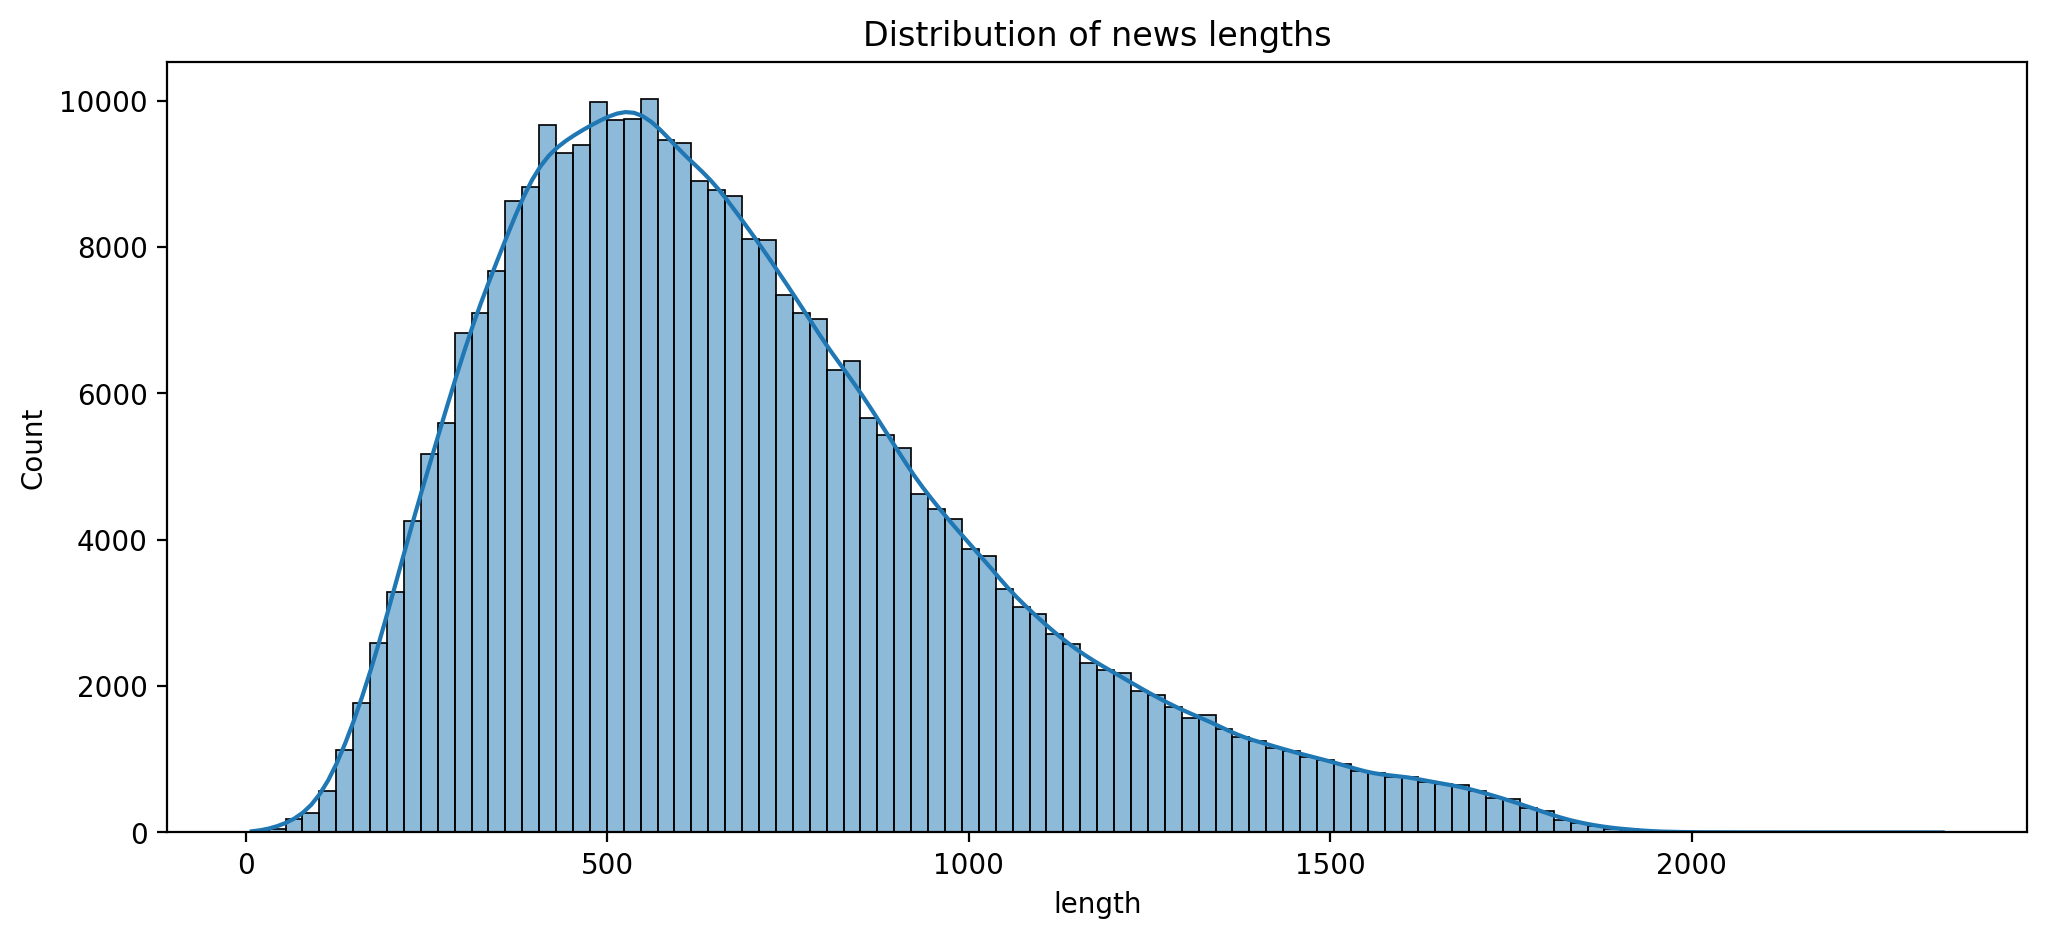

In [11]:
plot('news')

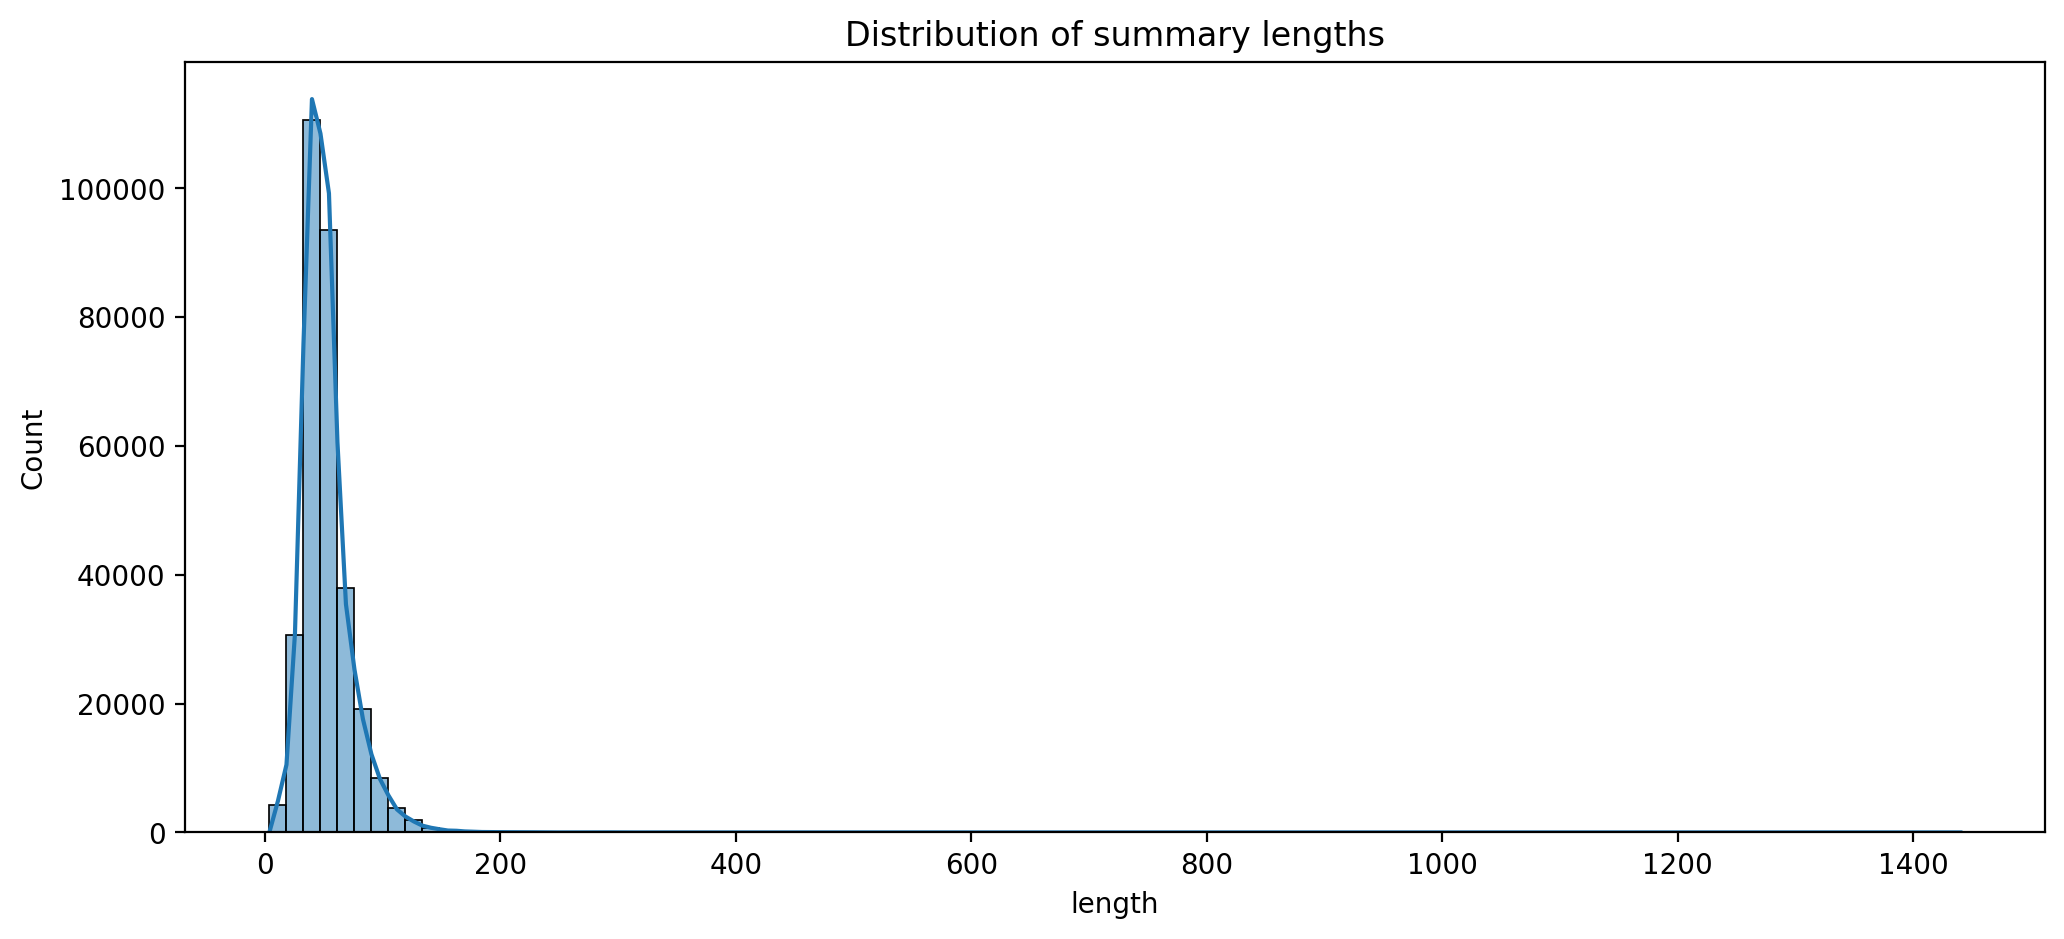

In [12]:
plot('summary')

# Prompt Template for News Summarization:

In [13]:
template = """Role:

You are a highly advanced language model designed to summarize news articles concisely and accurately. Your task is to summarise news articles such that it captures the main points, key details, and overall context. The summary should be clear, coherent, and should highlight the most important aspects of the news article.


Instructions:
1. Carefully read the news article given in the 'News' section.
2. In the 'Summary' section, provide a summary of the news article highlighting the main points, key details, and overall context.

**NOTE:** Only output the summary without any other additional texts.


News:

{news}


Summary: \n\n
"""

# Function for Coloring and Formatting Text:

In [14]:
def colorize_text(text):
    for word, color in zip(["Role", "Instructions", "News", "Summary"],
                           ["green", "yellow", "red", "cyan"]):
        text = text.replace(f"{word}:", f"\n\n**<font color='{color}' size=4>{word}:</font>**")
    return text

In [15]:
# Visualizing a random example:

row = train_dataset.loc[random.randint(0, len(train_dataset))]
example = f"{template.format(news=row.news)} \n{row.summary}"
display(Markdown(colorize_text(example)))



**<font color='green' size=4>Role:</font>**

You are a highly advanced language model designed to summarize news articles concisely and accurately. Your task is to summarise news articles such that it captures the main points, key details, and overall context. The summary should be clear, coherent, and should highlight the most important aspects of the news article.




**<font color='yellow' size=4>Instructions:</font>**
1. Carefully read the news article given in the 'News' section.
2. In the 'Summary' section, provide a summary of the news article highlighting the main points, key details, and overall context.

**NOTE:** Only output the summary without any other additional texts.




**<font color='red' size=4>News:</font>**

By . Anthony Bond . Last updated at 10:15 AM on 2nd March 2012 . A heartbroken mother gave birth just five hours after the funeral of her baby's father. Grieving Kelly Jones, 26, went into labour at the graveside of her fiancé killed in a car crash just days earlier. Miss Jones was eight months pregnant when her childhood sweetheart Ricky Norman, 27, died in the country road accident. Tragic: Grieving Kelly Jones went into labour at the graveside of her fiance killed in a car crash just days earlier. She is pictured here with baby Ava . She was determined to go to his funeral - but her midwife insisted on being at her side. Miss Jones managed to get through the service but strong labour pains began as she knelt to lay roses on Mr Norman's grave. She was rushed to hospital from the cemetery - and gave birth to baby Ava five hours later. Miss Jones said: 'It was a tragic day - we said goodbye to Ricky on the same day that Ava said hello to the world. 'Giving birth should have been one of the happiest days of our lives together and Ricky would have been at my side. 'My family and friends are saying Ava is Ricky's parting gift to me and that's the way I will always think of her.' One in a million: Ricky Norman was on his way to work when his car was in a head-on crash with a lorry on an icy mountain road . Mr Norman, a railway maintenance engineer, was on his way to work when his car was in a head-on crash with a lorry on an icy mountain road. He had chosen his unborn baby girl's name just the day before - Ava Rikki Leigh Norman-Jones. Miss Jones said: 'When I heard the news I was crying all day - it didn't feel real to me. 'I felt like I was dreaming and all I wanted to do was wake up from a nightmare. 'If it wasn't for me expecting Ava, I don't think I would have been able to cope.' Healthy Ava arrived three weeks early at Prince Charles Hospital in Merthyr Tydfil, South Wales, just a mile from the cemetery where her father was buried that day. Holding baby Ava close, Miss Jones said: 'It's as if it was meant to be, as if he wanted to see her there that day. 'Ricky would have loved Ava so much. I can't believe he is gone. 'He was a one-in-a-million, everything a woman would want in a man. He was kind, caring and changed my life forever.' The family will now never forget February 22 - the day Mr Norman was buried and his daughter was born. Miss Jones, of Merthyr Tydfil, said: 'I don't know how I will feel on her birthday - part of me will be celebrating for Ava, but part of me will be grieving for Ricky.' The couple have another son, one-year-old Jackson, and were planning to marry next year. Mr Norman's mother Sylvia Norman, 47, also told how her world has been 'turned upside down' following the loss of her son. She said: 'I cannot explain it myself. I had just laid my son to rest and hours later his daughter was born. 'It will never be the same without our son. We loved him dearly, he was our life. 'The children are the only thing keeping me going. We've got to be there for Ava. That's what Ricky would've wanted. 'He knew how hard it was going to be for us. That's why Ava was born on that day. It was his present to us.' Police are still investigating the crash in which Mr Norman and work colleague Robert McGovern, 35, were killed at Storey Arms in the Brecon Beacons.




**<font color='cyan' size=4>Summary:</font>** 


 
Kelly Jones, 26, went into labour as she knelt to lay flowers at the grave of Ricky Norman, 27 .
Mr Norman died in country road car crash .
Baby Ava was born three weeks early .

# Loading the Gemma 3 Model with 1 Billion Parameters:

In [16]:
gemma3_1b = keras_nlp.models.Gemma3CausalLM.from_preset("gemma3_1b")
gemma3_1b.summary()

I0000 00:00:1747329713.541950      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


Preprocessor: "gemma3_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma3_tokenizer (Gemma3Tokenizer)                            │                      Vocab size: 262,144 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma3_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma3_backbone               │ (None, None, 1152)        │     999,885,952 │ padding_mask[0][0],        │
│ (Gemma3Backbone)              │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 262144)      │     301,989,888 │ gemma3_backbone[0][0]      │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 999,885,952 (3.72 GB)

 Trainable params: 999,885,952 (3.72 GB)

 Non-trainable params: 0 (0.00 B)

# Model Inference Before Fine-tuning:

In [17]:
def generate_inference(dataset=test_dataset, example_num=None):
    """
    This function will generate the model inference, extract the summary and return the colored and formatted text.
    """
    
    if example_num == None or example_num >= len(dataset):
        example_num = random.randint(0, len(dataset)-1)

    row = dataset.loc[example_num]
    article = row.news
    summary = row.summary
    prompt = template.format(news = article)
    max_length = 2 * len(prompt.split()) # set the max output length to twice the length of the input prompt
    response = gemma3_1b.generate(prompt, max_length = max_length)
    response = response.split("Summary: \n\n")[-1].strip() # Extract only the summary text
    
    colored_text = f"<center><font color='Yellow' size='6'>Example {example_num}:</font></center>\n\n"
    colored_text += f"{prompt} \n{summary}"
    colored_text += f"<center><font color='Yellow' size='6'>Gemma 3 Output:</font></center>\n\n"
    colored_text += f"Summary: \n\n{response}"

    return colorize_text(colored_text)

In [18]:
display(Markdown(generate_inference(example_num=10853)))

I0000 00:00:1747329752.730854      19 service.cc:148] XLA service 0x8d1d7800 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747329752.731724      19 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1747329759.422869      19 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1747329770.924957      19 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


<center><font color='Yellow' size='6'>Example 10853:</font></center>



**<font color='green' size=4>Role:</font>**

You are a highly advanced language model designed to summarize news articles concisely and accurately. Your task is to summarise news articles such that it captures the main points, key details, and overall context. The summary should be clear, coherent, and should highlight the most important aspects of the news article.




**<font color='yellow' size=4>Instructions:</font>**
1. Carefully read the news article given in the 'News' section.
2. In the 'Summary' section, provide a summary of the news article highlighting the main points, key details, and overall context.

**NOTE:** Only output the summary without any other additional texts.




**<font color='red' size=4>News:</font>**

Mark Selby, John Higgins and Ding Junhui were among a number of players who moved effortlessly into the last 16 of the China Open on Wednesday. Selby, who is gearing up for the defence of his world title later this month, continued to defy a neck injury to sweep aside fellow Englishman Elliot Slessor with a break of 126 in frame four of their second-round clash. Ding, the home favourite and reigning champion in Beijing, had two breaks of 86 in a convincing 5-1 victory against Mark Davis to set up a third-round meeting with Mark Williams, who was an easy 5-0 winner over Scotland's Michael Leslie. Mark Selby plays a shot during his match against fellow Engllishman Elliot Slessor at the China Open . Slessor plays a shot against Selby during their match at the China Open at Peking University in Beijing . Four-time world champion Higgins had a single break over 50 as he beat Scottish countryman Graeme Dott 5-2, setting up an intriguing last-16 clash with Judd Trump. Bristolian Trump, who lost out to Higgins in the 2011 World Championship final, enjoyed a century break in frame six to seal a 5-1 success against Peter Ebdon. Another former world champion, Shaun Murphy, was made to work hard for his place in the third round, coming from 3-2 down to see off Anthony McGill 5-4. Thailand's Dechawat Poomjaeng, who upset Neil Robertson in the opening round in Beijing, pulled out an impressive 5-0 win against England's Jack Lisowski to continue his challenge, but it was the end of the line for Marco Fu, who was edged out 5-4 by Welshman Jamie Jones. There were also second-round wins for Barry Hawkins, Stephen Maguire, Michael White, Robert Milkins, David Gilbert, Robin Hull, Kurt Maflin and Gary Wilson, with the last-16 taking place across two sessions on Thursday. Shaun Murphy worked hard for his place in the third round, coming from behind to beat Anthony McGill 5-4 .




**<font color='cyan' size=4>Summary:</font>** 


 
World No 1 Mark Selby overcame a neck injury to beat fellow Englishman Elliot Slessor at the China Open .
John Higgins and Ding Junhui have also made it into the tournament's last 16 .
Shaun Murphy was made to work hard for his place in the third round, coming back from 3-2 down to beat Anthony McGill .
The last 16 will take place across two sessions on Thursday .<center><font color='Yellow' size='6'>Gemma 3 Output:</font></center>



**<font color='cyan' size=4>Summary:</font>** 

Mark Selby, John Higgins and Ding Junhui were among a number of players who moved effortlessly into the last 16 of the China Open on Wednesday. Selby, who is gearing up for the defence of his world title later this month, continued to defy a neck injury to sweep aside fellow Englishman Elliot Slessor with a break of 126 in frame four of their second-round clash. Ding, the home favourite and reigning champion in Beijing, had two breaks of 86 in a convincing 5-1 victory against fellow Scottish countryman Graeme Dott to set up a third-round meeting with Mark Williams, who was an easy 5-0 winner over Scotland's Michael Leslie. Mark Selby plays a shot during his match against fellow Engllishman Elliot Slessor at the China Open . Slessor plays a shot against Selby during their match at the China Open at Peking University in Beijing . Four-time world champion Higgins had a single break over 50 as he beat Scottish countryman Graeme Dott 5-2, setting up an intriguing last-16 clash with Judd Trump. Bristolian Trump, who lost out to Higgins in the 2011 World Championship final, enjoyed a century break in frame six to seal a 5-1 success against Peter E

In [19]:
display(Markdown(generate_inference()))

<center><font color='Yellow' size='6'>Example 4401:</font></center>



**<font color='green' size=4>Role:</font>**

You are a highly advanced language model designed to summarize news articles concisely and accurately. Your task is to summarise news articles such that it captures the main points, key details, and overall context. The summary should be clear, coherent, and should highlight the most important aspects of the news article.




**<font color='yellow' size=4>Instructions:</font>**
1. Carefully read the news article given in the 'News' section.
2. In the 'Summary' section, provide a summary of the news article highlighting the main points, key details, and overall context.

**NOTE:** Only output the summary without any other additional texts.




**<font color='red' size=4>News:</font>**

British No 2 Aljaz Bedene has booked a quarter-final place at the Grand Prix Hassan II event in Casablanca. The world No 99, who switched allegiance from Slovenia to Britain last month, knocked out fellow qualifier Arthur De Greef, of Belgium, 6-2, 6-3 in just 70 minutes. London-based Bedene, 25, will now face third seed Jiri Vesely, who was given a far tougher test as he progressed to the last-eight. British number two Aljaz Bedene, pictured in June 2013, defeated Arthur De Greef in just 70 minutes . Bedene represents Great Britain after switching allegiance from Slovenia in March . Czech Vesely claimed his first victory of the year on clay, but only after saving a set-point against former world top-10 player Mikhail Youzhny to progress 7-6 (9/7), 6-3. Top seed and defending champion Guillermo Garcia-Lopez, though, suffered a surprise defeat, bowing out 6-3, 6-3 against Morocco's world number 313 and wild card entry Lamine Ouahab. Ouahab next faces Spaniard Daniel Gimeno-Traver, who held a 6-1, 4-1 lead against seventh seed Mikhail Kukushkin, before he was forced to retire.




**<font color='cyan' size=4>Summary:</font>** 


 
Slovenian-born Aljaz Bedene defeated Belgium's Arthur De Greef .
Bedene will face Jiri Vesely after beating Arthur De Greef in 70 minutes .
The 25-year-old switched allegiance from Slovenia to Britain in March .<center><font color='Yellow' size='6'>Gemma 3 Output:</font></center>



**<font color='cyan' size=4>Summary:</font>** 

The news article provided is about a British No 2 Aljaz Bedene who has booked a quarter-final place at the Grand Prix Hassan II event in Casablanca. The world No 99, who switched allegiance from Slovenia to Britain last month, knocked out fellow qualifier Arthur De Greef, of Belgium, 6-2, 6-3 in just 70 minutes. London-based Bedene, 25, will now face third seed Jiri Vesely, who was given a far tougher test as he progressed to the last-eight. British number two Aljaz Bedene, pictured in June 201

# Building TensorFlow Datatsets:

In [20]:
def build_tf_dataset(dataset):
    AUTO = tf.data.AUTOTUNE
    options = tf.data.Options()
    options.experimental_deterministic = False
    
    # Randomly sample 500 records for faster training
    dataset = dataset.sample(n=500)

    # Convert the dataframe into a dictionary with keys "prompts" and "responses"
    dataset_dict_list = []
    for i in range(len(dataset)):
        dataset_dict = dict()
        dataset_dict["prompts"] = template.format(news=dataset.iloc[i, 0])
        dataset_dict["responses"] = dataset.iloc[i, 1]
        dataset_dict_list.append(dataset_dict)

    dataset = tf.data.Dataset.from_generator(
        lambda: (item for item in dataset_dict_list),
        output_signature={
            "prompts": tf.TensorSpec(shape=(), dtype=tf.string),
            "responses": tf.TensorSpec(shape=(), dtype=tf.string),
        }
    )

    dataset = dataset.cache().shuffle(1024, seed=42)
    dataset = dataset.with_options(options).batch(1).prefetch(AUTO)

    return dataset

In [21]:
train_dataset = build_tf_dataset(train_dataset)
# valid_dataset = build_tf_dataset(valid_dataset)

# Fine-tuning with LoRA:

In [22]:
gemma3_1b.backbone.enable_lora(rank=4)
gemma3_1b.summary()

Preprocessor: "gemma3_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma3_tokenizer (Gemma3Tokenizer)                            │                      Vocab size: 262,144 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma3_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma3_backbone               │ (None, None, 1152)        │   1,000,538,240 │ padding_mask[0][0],        │
│ (Gemma3Backbone)              │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 262144)      │     301,989,888 │ gemma3_backbone[0][0]      │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 1,000,538,240 (3.73 GB)

 Trainable params: 652,288 (2.49 MB)

 Non-trainable params: 999,885,952 (3.72 GB)

In [23]:
gemma3_1b.preprocessor.sequence_length = 1024

optimizer = keras.optimizers.AdamW(
    learning_rate=5e-5,
    weight_decay=0.01,
)

# Exclude layernorm and bias terms from decay.
optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])

In [24]:
gemma3_1b.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

In [25]:
history = gemma3_1b.fit(train_dataset, epochs=25)

Epoch 1/25


W0000 00:00:1747329893.088989      74 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


500/500 ━━━━━━━━━━━━━━━━━━━━ 419s 629ms/step - loss: 0.1302 - sparse_categorical_accuracy: 0.5832
Epoch 2/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 315s 629ms/step - loss: 0.1175 - sparse_categorical_accuracy: 0.6191
Epoch 3/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 314s 628ms/step - loss: 0.1020 - sparse_categorical_accuracy: 0.6407
Epoch 4/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 314s 628ms/step - loss: 0.1028 - sparse_categorical_accuracy: 0.6406
Epoch 5/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 315s 629ms/step - loss: 0.1097 - sparse_categorical_accuracy: 0.6359
Epoch 6/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 315s 629ms/step - loss: 0.1030 - sparse_categorical_accuracy: 0.6467
Epoch 7/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 314s 628ms/step - loss: 0.1024 - sparse_categorical_accuracy: 0.6536
Epoch 8/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 314s 628ms/step - loss: 0.0966 - sparse_categorical_accuracy: 0.6572
Epoch 9/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 315s 629ms/step - loss: 0.0957 - sparse_categorical_accuracy: 0.6558
Epoch 10/25
500/500 ━━━━━━━━━━

# Plotting Training Metric:

In [26]:
def plot_model_metric(metric):
    plt.figure(dpi=120)
    plt.plot(history.history[metric], label=metric)
    # plt.plot(history.history[f'val_{metric}'], label=f'val_{metric}')
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.legend()
    plt.title(f'{metric} over Epochs')
    plt.show();

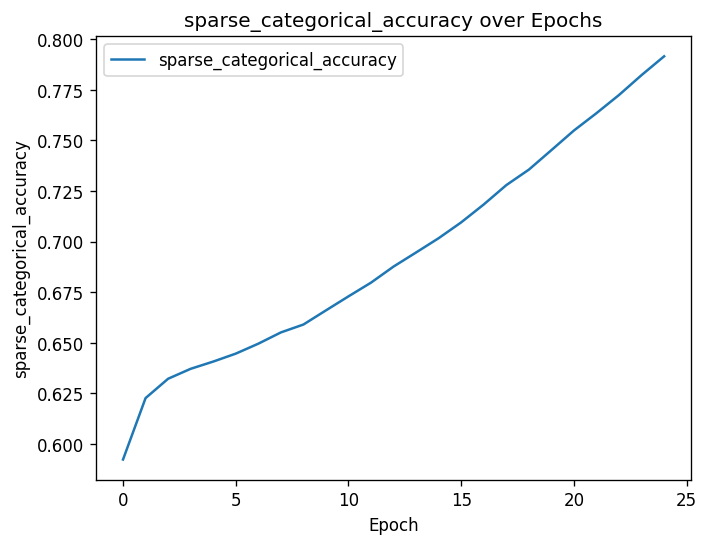

In [27]:
plot_model_metric('sparse_categorical_accuracy')

# Inference After Fine-tuning:

In [28]:
display(Markdown(generate_inference(example_num=10853)))

<center><font color='Yellow' size='6'>Example 10853:</font></center>



**<font color='green' size=4>Role:</font>**

You are a highly advanced language model designed to summarize news articles concisely and accurately. Your task is to summarise news articles such that it captures the main points, key details, and overall context. The summary should be clear, coherent, and should highlight the most important aspects of the news article.




**<font color='yellow' size=4>Instructions:</font>**
1. Carefully read the news article given in the 'News' section.
2. In the 'Summary' section, provide a summary of the news article highlighting the main points, key details, and overall context.

**NOTE:** Only output the summary without any other additional texts.




**<font color='red' size=4>News:</font>**

Mark Selby, John Higgins and Ding Junhui were among a number of players who moved effortlessly into the last 16 of the China Open on Wednesday. Selby, who is gearing up for the defence of his world title later this month, continued to defy a neck injury to sweep aside fellow Englishman Elliot Slessor with a break of 126 in frame four of their second-round clash. Ding, the home favourite and reigning champion in Beijing, had two breaks of 86 in a convincing 5-1 victory against Mark Davis to set up a third-round meeting with Mark Williams, who was an easy 5-0 winner over Scotland's Michael Leslie. Mark Selby plays a shot during his match against fellow Engllishman Elliot Slessor at the China Open . Slessor plays a shot against Selby during their match at the China Open at Peking University in Beijing . Four-time world champion Higgins had a single break over 50 as he beat Scottish countryman Graeme Dott 5-2, setting up an intriguing last-16 clash with Judd Trump. Bristolian Trump, who lost out to Higgins in the 2011 World Championship final, enjoyed a century break in frame six to seal a 5-1 success against Peter Ebdon. Another former world champion, Shaun Murphy, was made to work hard for his place in the third round, coming from 3-2 down to see off Anthony McGill 5-4. Thailand's Dechawat Poomjaeng, who upset Neil Robertson in the opening round in Beijing, pulled out an impressive 5-0 win against England's Jack Lisowski to continue his challenge, but it was the end of the line for Marco Fu, who was edged out 5-4 by Welshman Jamie Jones. There were also second-round wins for Barry Hawkins, Stephen Maguire, Michael White, Robert Milkins, David Gilbert, Robin Hull, Kurt Maflin and Gary Wilson, with the last-16 taking place across two sessions on Thursday. Shaun Murphy worked hard for his place in the third round, coming from behind to beat Anthony McGill 5-4 .




**<font color='cyan' size=4>Summary:</font>** 


 
World No 1 Mark Selby overcame a neck injury to beat fellow Englishman Elliot Slessor at the China Open .
John Higgins and Ding Junhui have also made it into the tournament's last 16 .
Shaun Murphy was made to work hard for his place in the third round, coming back from 3-2 down to beat Anthony McGill .
The last 16 will take place across two sessions on Thursday .<center><font color='Yellow' size='6'>Gemma 3 Output:</font></center>



**<font color='cyan' size=4>Summary:</font>** 

Mark Selby wins forthime world title defence .
Ding Junhui also into last 16 after two breaks of 86 .
Higgins has one break of 126 in impressive win over Slessor .
Another former world champion, Higgins, has third round clash .
Trump, who lost out to Higgins in 2011 World Championship final, wins 5-1 .
Thailand's Dechawat Poomjaeng also into last 16 .

In [29]:
display(Markdown(generate_inference()))

<center><font color='Yellow' size='6'>Example 6604:</font></center>



**<font color='green' size=4>Role:</font>**

You are a highly advanced language model designed to summarize news articles concisely and accurately. Your task is to summarise news articles such that it captures the main points, key details, and overall context. The summary should be clear, coherent, and should highlight the most important aspects of the news article.




**<font color='yellow' size=4>Instructions:</font>**
1. Carefully read the news article given in the 'News' section.
2. In the 'Summary' section, provide a summary of the news article highlighting the main points, key details, and overall context.

**NOTE:** Only output the summary without any other additional texts.




**<font color='red' size=4>News:</font>**

Ahead of this weekend's Premier League action, Sportsmail will be providing you with all you need to know about every fixture, with team news, provisional squads, betting odds and Opta stats. Here is all the information you need for Leicester's home clash with West Ham... Leicester City vs West Ham United (King Power Stadium) Team news . Leicester City . Matt Upson is out of Leicester's clash with West Ham as the rock-bottom Foxes continue their fight for survival. The defender limped off in their 4-3 defeat by Tottenham before the international break with an achilles problem and will not be risked. Jeff Schlupp (right) trains with Leicester team-mate Wes Morgan on Thursday but could be rested by the Foxes . Dean Hammond (calf) is out and Jeff Schlupp will be assessed after he played in Ghana's 1-1 draw with Mali on Tuesday with boss Nigel Pearson admitting the winger is tired, while Liam Moore has returned from a loan at Brentford. Provisional squad: Schmeichel, Schwarzer, Hamer, Simpson, Moore, Wasilewski, Morgan, Huth, De Laet, Konchesky, King, Knockaert, Albrighton, Schlupp, Cambiasso, James, Mahrez, Nugent, Kramaric, Vardy, Ulloa. West Ham United . West Ham will welcome Winston Reid back from injury for Saturday's Premier League trip to bottom side Leicester. The New Zealand defender has been struggling with a hamstring problem but worked on his fitness over the international break and is now in contention to face the Foxes. West Ham United's Winston Reid tackles Tottenham Hotspur's Mousa Dembele during a 2-2 Premier League clash at White Hart Lane in February . Hammers' boss Sam Allardyce believes the game will come too soon for Enner Valencia (toe) but the Ecuadorian is back in training whilst Andy Carroll (knee), James Tomkins (shoulder) and Doneil Henry (hamstring) all miss out. Provisional squad: Adrian, Jaaskelainen, Cresswell, Jenkinson, Reid, Collins, O'Brien, Noble, Poyet, Song, Amalfitano, Kouyate, Nolan, Downing, Jarvis, Nene, Sakho, Valencia, Cole. Kick-off: Saturday, 3pm . Odds (subject to change): . Leicester 7/5 . Draw 11/5 . West Ham 2/1 . Referee: Mark Clattenburg . Managers: Nigel Pearson (Leicester), Sam Allardyce (West Ham) Head-to-head league record: Leicester wins 39, draws 29, West Ham wins 51 . Key match stats (supplied by Opta) Leicester have won just one of their last 10 Premier League home matches (W1 D3 L6). West Ham United are unbeaten in their last seven league games against Leicester City (W4 D3 L0). The Hammers scored with their only two shots on target in their 2-0 win in the reverse fixture against the Foxes back in December. Sam Allardyce’s team have won none of their last seven Barclays Premier League away matches (W0 D4 L3). West Ham have kept just one clean sheet in their last 20 Premier League games on the road. Andy Carroll will not feature for West Ham United at Leicester City but he did score in the Hammers' 2-0 victory over the Foxes back in December . Nigel Pearson’s side have scored just three goals in their last nine Premier League games at the King Power Stadium and have gone five hours and 15 minutes since they lasted netted in front of their own fans. West Ham will be looking to win back to back Premier League games for the first time since December 7th. No ground has seen fewer Premier League goals this season than the King Power Stadium (30, level with Villa Park). After scoring five goals in his first five Premier League appearances for Leicester City, Leonardo Ulloa has scored only two in his 23 apps since. Diafra Sakho has scored a league-high five headed goals this season, while only Graziano Pellè (25) has attempted more headed shots than the Hammer (23).




**<font color='cyan' size=4>Summary:</font>** 


 
Leicester defender Matthew Upson will miss out against former club .
Dean Hammond and Jeff Schlupp to be given fitness tests by Foxes .
Winston Reid returns from hamstring injury for West Ham United .
Hammers without Enner Valencia who is back in training .
Andy Carroll, James Tomkins and Doneil Henry also missing for West Ham .<center><font color='Yellow' size='6'>Gemma 3 Output:</font></center>



**<font color='cyan' size=4>Summary:</font>** 

West Ham United host bottom side Leicester City at the London Stadium on Saturday .
Sam Allardyce's side have won just one of their last nine Premier League games on the road .
Leicester have scored three goals in their last five Premier League games .